<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/June21_2000_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="border-radius:10px;
    border:#410159 solid;
    background-color:#fef1ff;
    font-size:110%;
    letter-spacing:0.5px;
    text-align: center">
<center><h1 style="padding: 25px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Home credit default risk</h1></center>
<center><h3 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">With LightGBM classifier</h3></center>
<center><h4 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">(Second challenge)</h4></center>
</div>

In [1]:
import numpy as np 
import pandas as pd 

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2"

Mounted at /content/drive
/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# ----------------------------------------------------
from lightgbm import LGBMClassifier

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Define functions

In [4]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

# Data Understanding

In [5]:
# IPython magic to ensure Python compatibility.
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,...,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,...,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [7]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60

In [8]:
train.shape

(171202, 51)

0    157381
1     13821
Name: TARGET, dtype: int64

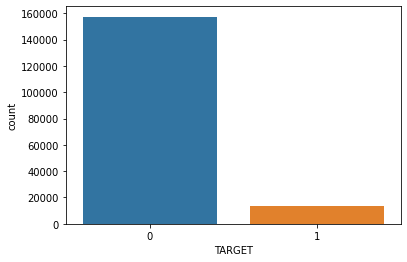

In [9]:
sns.countplot(x = "TARGET", data = train)
train.loc[:, 'TARGET'].value_counts()

In [10]:
print(train.info())
print("*******************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   FLAG_OWN_REALTY              136961 non-null  object 
 6   CNT_CHILDREN                 171202 non-null  int64  
 7   AMT_INCOME_TOTAL             171202 non-null  float64
 8   AMT_CREDIT                   171202 non-null  float64
 9   AMT_ANNUITY                  171196 non-null  float64
 10  AMT_GOODS_PRICE              171039 non-null  float64
 11  NAME_TYPE_SUITE              170455 non-null  object 
 12  NAME_INCOME_TYPE             171202 non-null  object 
 13 

In [11]:
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,171202.0,85600.500000,49421.904730,0.000000e+00,42800.250000,85600.500000,128400.750000,1.712010e+05
TARGET,171202.0,0.080729,0.272420,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,171202.0,0.416490,0.720138,0.000000e+00,0.000000,0.000000,1.000000,1.400000e+01
AMT_INCOME_TOTAL,171202.0,168371.213673,107234.793540,2.610000e+04,112500.000000,146250.000000,202500.000000,1.350000e+07
AMT_CREDIT,171202.0,599129.309526,402816.996913,4.500000e+04,270000.000000,514602.000000,808650.000000,4.050000e+06
AMT_ANNUITY,171196.0,27127.500701,14538.361801,1.980000e+03,16546.500000,24916.500000,34600.500000,2.580255e+05
AMT_GOODS_PRICE,171039.0,538466.926517,369692.126605,4.500000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,171202.0,0.020839,0.013803,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,171202.0,-16045.340504,4363.792228,-2.522900e+04,-19686.000000,-15778.000000,-12420.000000,-7.673000e+03
DAYS_EMPLOYED,171202.0,63960.411969,141401.513149,-1.791200e+04,-2772.000000,-1215.000000,-288.000000,3.652430e+05


In [12]:
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_1,118928
OWN_CAR_AGE,112992
EXT_SOURCE_3,54586
OCCUPATION_TYPE,53745
FLAG_OWN_CAR,34241
FLAG_OWN_REALTY,34241
AMT_REQ_CREDIT_BUREAU_YEAR,23116
AMT_REQ_CREDIT_BUREAU_QRT,23116
AMT_REQ_CREDIT_BUREAU_HOUR,23116
AMT_REQ_CREDIT_BUREAU_MON,23116


In [13]:
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_1,42912
OWN_CAR_AGE,40909
EXT_SOURCE_3,19690
OCCUPATION_TYPE,18734
FLAG_OWN_CAR,12334
FLAG_OWN_REALTY,12334
AMT_REQ_CREDIT_BUREAU_YEAR,8513
AMT_REQ_CREDIT_BUREAU_MON,8513
AMT_REQ_CREDIT_BUREAU_QRT,8513
AMT_REQ_CREDIT_BUREAU_HOUR,8513


# Preprocessing

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
1. Numerical Field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [14]:
threshold_train = len(train) * 0.60
int(threshold_train)

102721

In [15]:
threshold_test = len(test) * 0.60
int(threshold_test)

36900

In [16]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1'], dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1'], dtype='object')


In [17]:
train_new = train.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(171202, 49)
******************************************
(61500, 48)


In [18]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [19]:
numeric = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]
numeric.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,112500.0,755190.0,36328.5,675000.0,0.010032,-9233,-878,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,0,225000.0,585000.0,16893.0,585000.0,0.008019,-20148,365243,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,0,54000.0,334152.0,18256.5,270000.0,0.004960,-18496,-523,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,0,67500.0,152820.0,8901.0,135000.0,0.005002,-24177,365243,...,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0,157500.0,271066.5,21546.0,234000.0,0.006296,-10685,-697,...,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [20]:
discrete_features = numeric.dtypes==int
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

#-------------------------------------------
discrete_features_test = numeric_test.dtypes==int
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

discrete.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,0,0,0,-9233,-878,-522,1,1,1,1,0,0,2,2,0,1,1,0,1,1
1,1,0,0,-20148,365243,-3436,1,0,0,1,0,0,2,2,0,0,0,0,0,0
2,2,0,0,-18496,-523,-2050,1,1,1,1,1,0,2,2,0,0,0,0,0,0
3,3,0,0,-24177,365243,-3951,1,0,0,1,1,0,3,3,0,0,0,0,0,0
4,4,1,0,-10685,-697,-3226,1,1,1,1,0,0,3,3,0,0,0,0,1,1


In [21]:
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
TARGET,0
REG_CITY_NOT_WORK_CITY,0
REG_CITY_NOT_LIVE_CITY,0
LIVE_REGION_NOT_WORK_REGION,0
REG_REGION_NOT_WORK_REGION,0
REG_REGION_NOT_LIVE_REGION,0
REGION_RATING_CLIENT_W_CITY,0
REGION_RATING_CLIENT,0
FLAG_EMAIL,0


In [22]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
FLAG_EMAIL,0
REG_CITY_NOT_WORK_CITY,0
REG_CITY_NOT_LIVE_CITY,0
LIVE_REGION_NOT_WORK_REGION,0
REG_REGION_NOT_WORK_REGION,0
REG_REGION_NOT_LIVE_REGION,0
REGION_RATING_CLIENT_W_CITY,0
REGION_RATING_CLIENT,0
FLAG_PHONE,0


In [23]:
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_features_test = numeric_test.dtypes==float
final_continuous_feature_test = numeric_test.columns[continuous_features_test].tolist()
continuous_test = numeric_test[final_continuous_feature_test]

continuous.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,112500.0,755190.0,36328.5,675000.0,0.010032,-333.0,2.0,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,225000.0,585000.0,16893.0,585000.0,0.008019,-4469.0,2.0,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,54000.0,334152.0,18256.5,270000.0,0.004960,-3640.0,2.0,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,67500.0,152820.0,8901.0,135000.0,0.005002,-4950.0,1.0,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,157500.0,271066.5,21546.0,234000.0,0.006296,-5101.0,2.0,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [24]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,54586
AMT_REQ_CREDIT_BUREAU_YEAR,23116
AMT_REQ_CREDIT_BUREAU_QRT,23116
AMT_REQ_CREDIT_BUREAU_MON,23116
AMT_REQ_CREDIT_BUREAU_HOUR,23116
DEF_60_CNT_SOCIAL_CIRCLE,560
OBS_60_CNT_SOCIAL_CIRCLE,560
DEF_30_CNT_SOCIAL_CIRCLE,560
OBS_30_CNT_SOCIAL_CIRCLE,560
EXT_SOURCE_2,369


In [25]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,19690
AMT_REQ_CREDIT_BUREAU_YEAR,8513
AMT_REQ_CREDIT_BUREAU_QRT,8513
AMT_REQ_CREDIT_BUREAU_MON,8513
AMT_REQ_CREDIT_BUREAU_HOUR,8513
DEF_60_CNT_SOCIAL_CIRCLE,181
OBS_60_CNT_SOCIAL_CIRCLE,181
DEF_30_CNT_SOCIAL_CIRCLE,181
OBS_30_CNT_SOCIAL_CIRCLE,181
EXT_SOURCE_2,130


In [26]:
continuous_col = continuous.columns

In [27]:
Q1 = train_new.quantile(0.25)
Q3 = train_new.quantile(0.75)
IQR = Q3 - Q1

*********************** AMT_INCOME_TOTAL ***********************

lower outlier: 0 ****** upper outlier: 7784



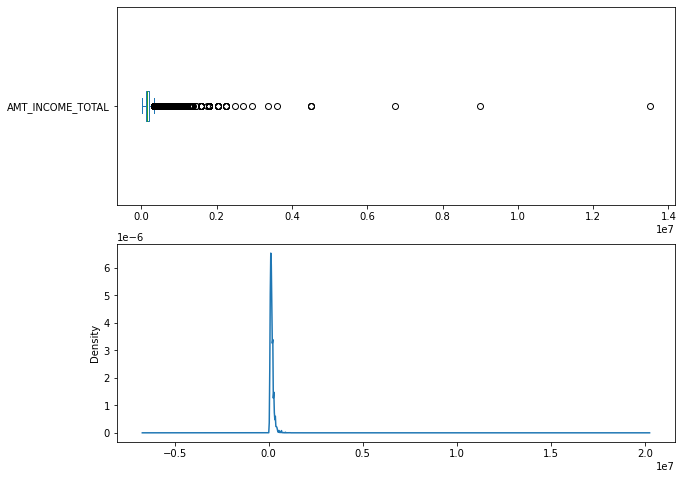

*********************** AMT_CREDIT ***********************

lower outlier: 0 ****** upper outlier: 3630



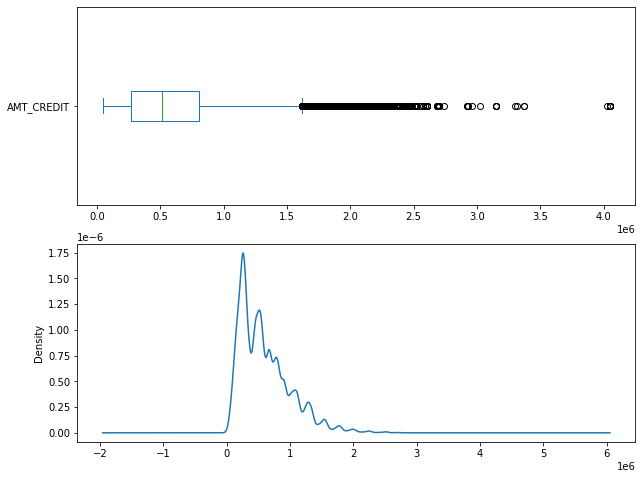

*********************** AMT_ANNUITY ***********************

lower outlier: 0 ****** upper outlier: 4179



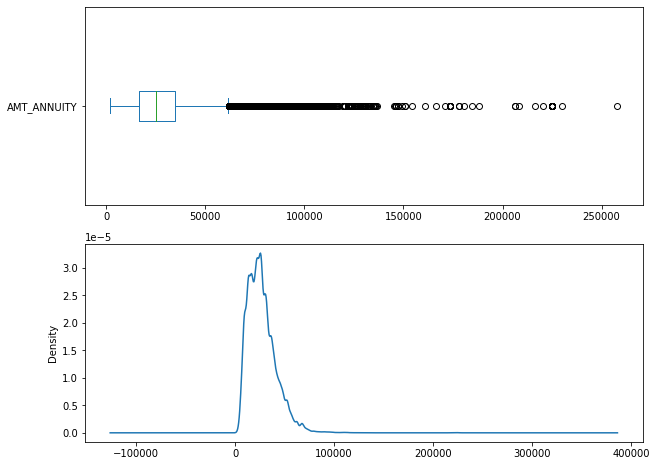

*********************** AMT_GOODS_PRICE ***********************

lower outlier: 0 ****** upper outlier: 8196



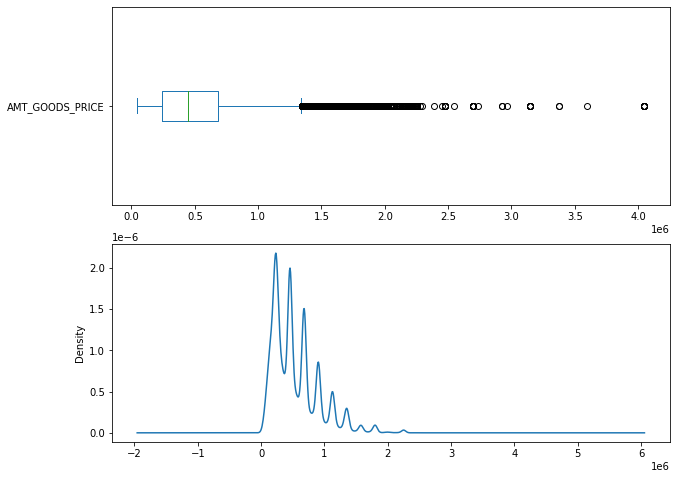

*********************** REGION_POPULATION_RELATIVE ***********************

lower outlier: 0 ****** upper outlier: 4624



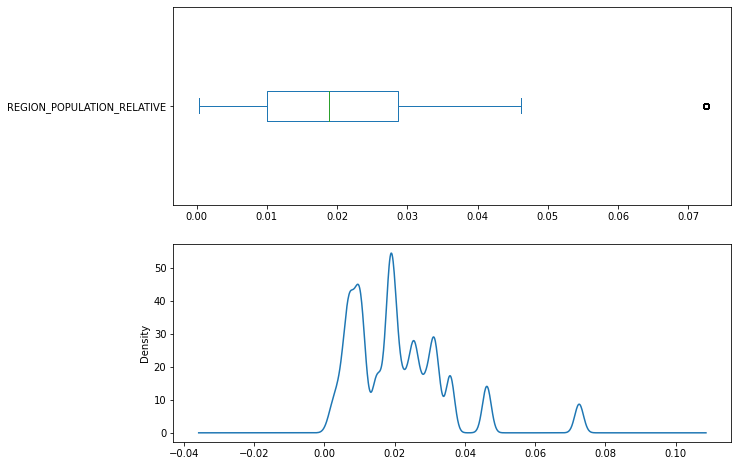

*********************** DAYS_REGISTRATION ***********************

lower outlier: 348 ****** upper outlier: 0



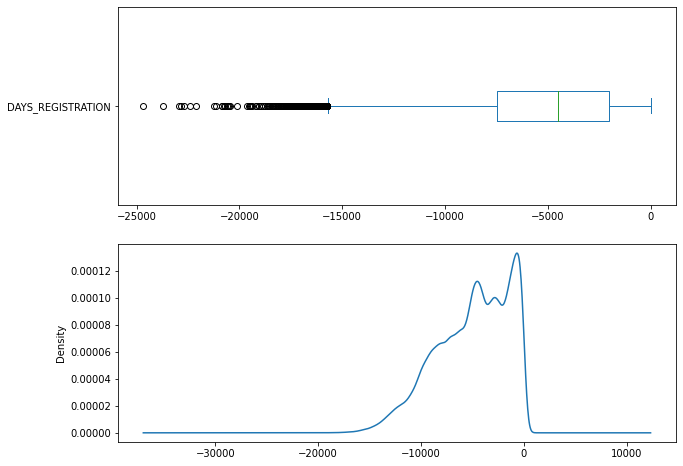

*********************** CNT_FAM_MEMBERS ***********************

lower outlier: 0 ****** upper outlier: 2184



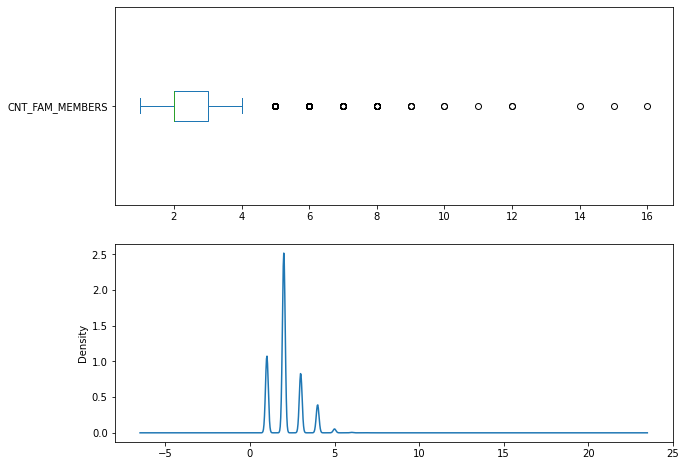

*********************** EXT_SOURCE_2 ***********************

lower outlier: 0 ****** upper outlier: 0



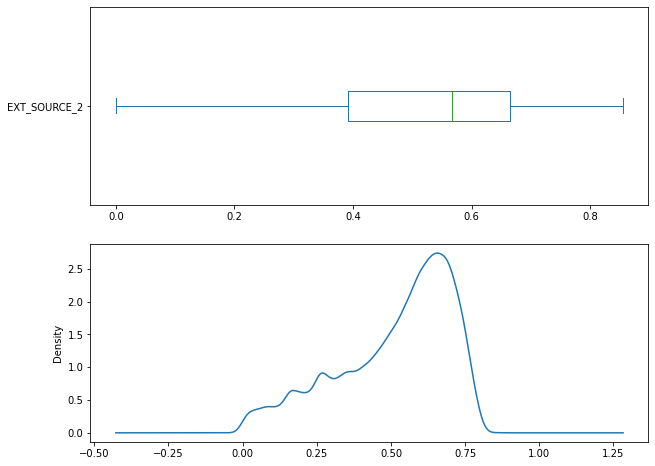

*********************** EXT_SOURCE_3 ***********************

lower outlier: 0 ****** upper outlier: 0



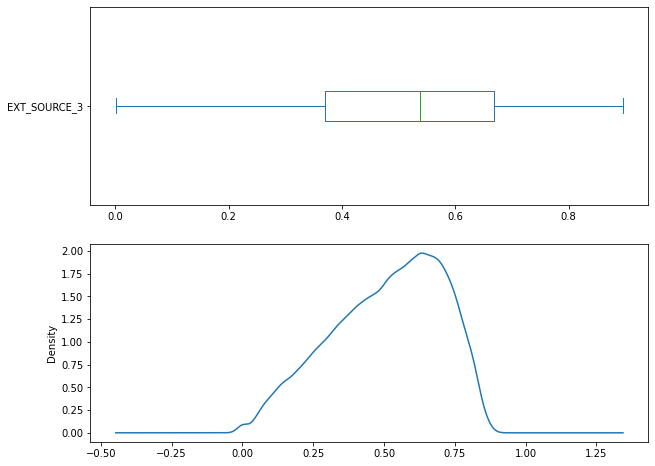

*********************** OBS_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 11146



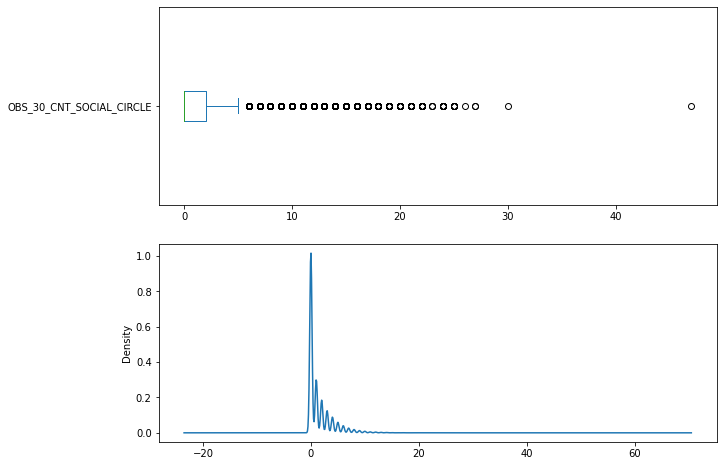

*********************** DEF_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19626



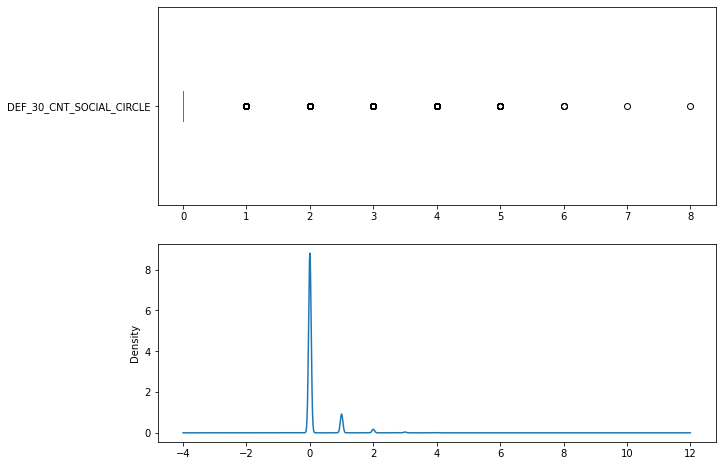

*********************** OBS_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 10904



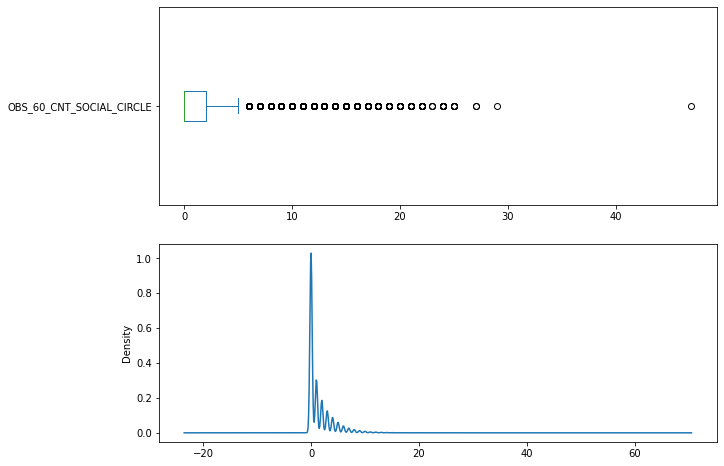

*********************** DEF_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 14422



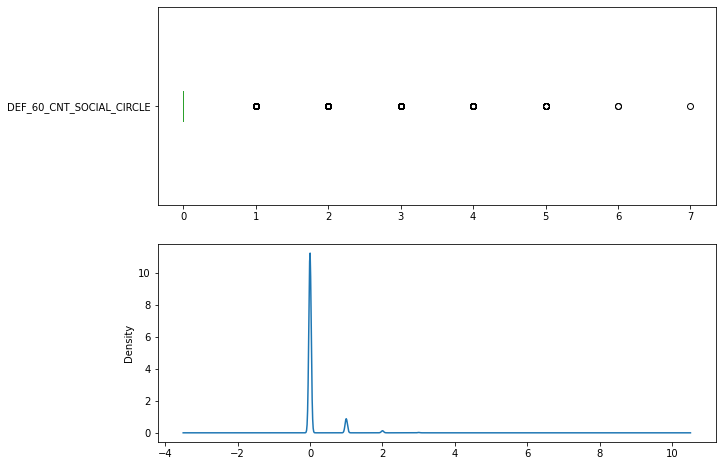

*********************** DAYS_LAST_PHONE_CHANGE ***********************

lower outlier: 250 ****** upper outlier: 0



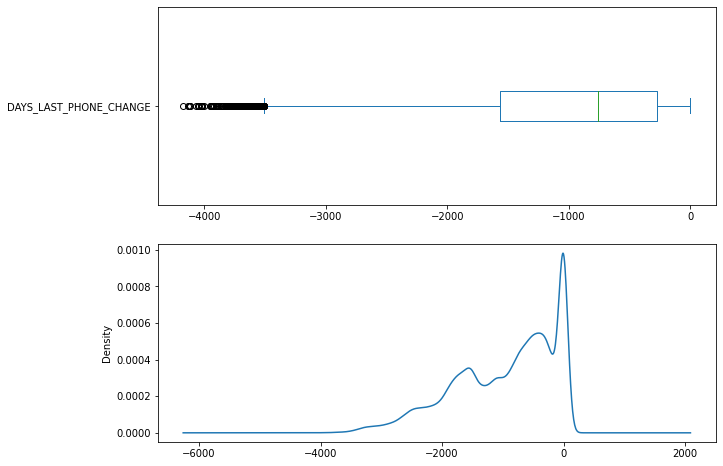

*********************** AMT_REQ_CREDIT_BUREAU_HOUR ***********************

lower outlier: 0 ****** upper outlier: 933



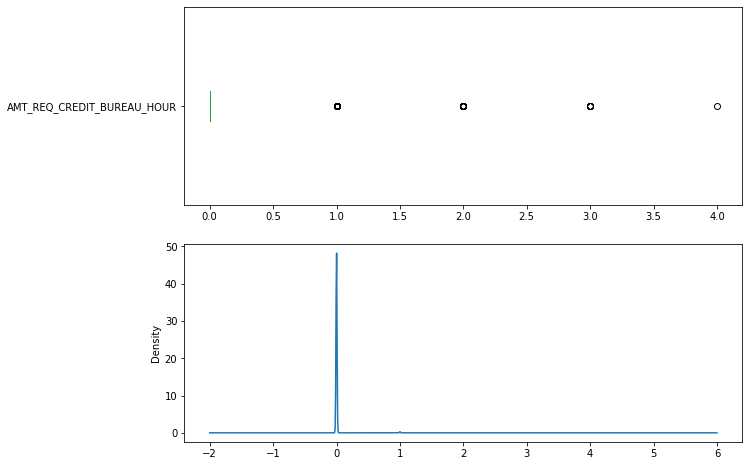

*********************** AMT_REQ_CREDIT_BUREAU_MON ***********************

lower outlier: 0 ****** upper outlier: 24353



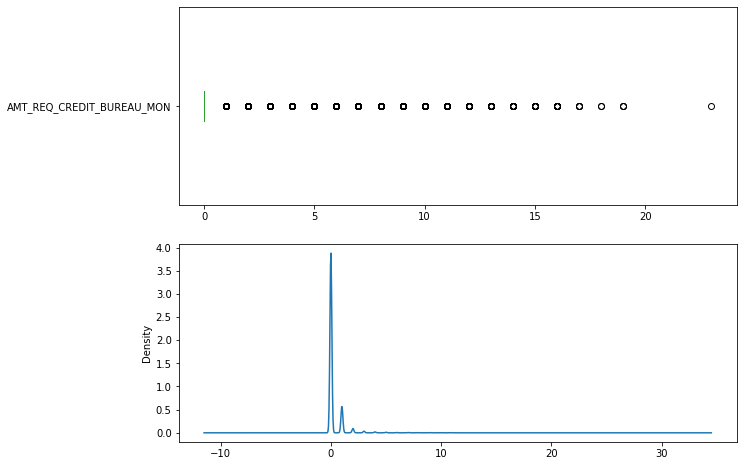

*********************** AMT_REQ_CREDIT_BUREAU_QRT ***********************

lower outlier: 0 ****** upper outlier: 28273



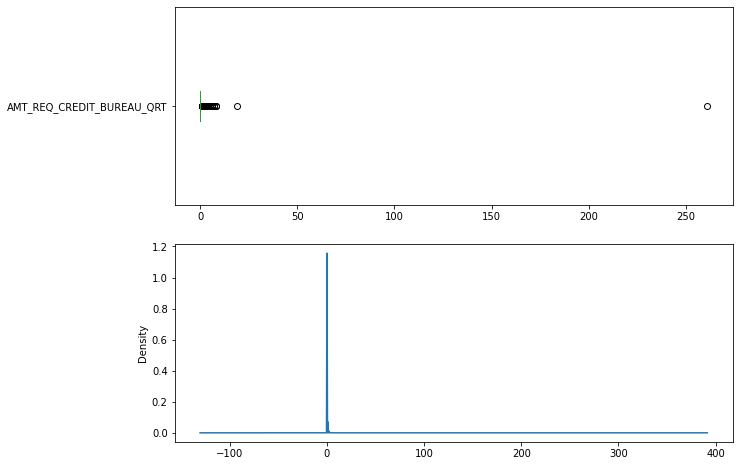

*********************** AMT_REQ_CREDIT_BUREAU_YEAR ***********************

lower outlier: 0 ****** upper outlier: 1858



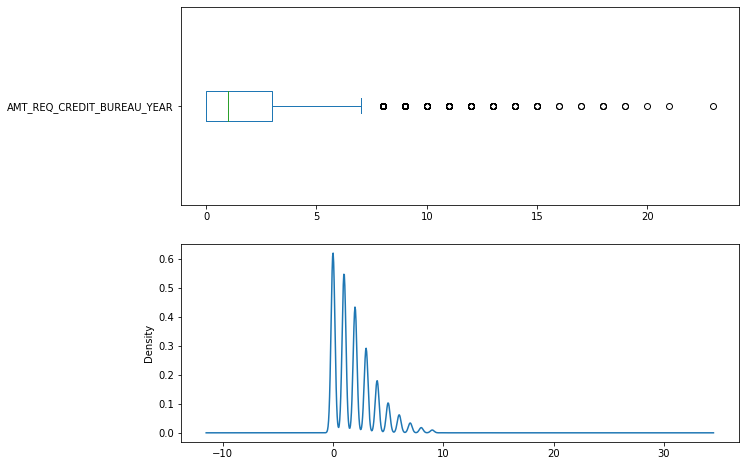

In [28]:
for i in range(len(continuous_col)):
    preprocess(continuous[continuous_col], continuous_col[i])

In [29]:
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
****************************************
In test: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [30]:
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27127.500700950957
NaN in AMT_GOODS_PRICE raplaced with 538466.9265167593
NaN in CNT_FAM_MEMBERS raplaced with 2.1523306074766353
NaN in EXT_SOURCE_2 raplaced with 0.5145082557908564
NaN in EXT_SOURCE_3 raplaced with 0.5111771488927158
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 1.4231373284420012
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.14391533151275773
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4064063946742302
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10043834460449358
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -962.411218392416
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.006651540321164728
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26841835149845356
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.26754723606552944
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.9036438285860915
************************************
In test:

NaN in AMT_ANNUITY raplaced with 27032.056490560517
NaN in AMT_GOODS_PRICE rapl

In [31]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0
DEF_30_CNT_SOCIAL_CIRCLE,0
OBS_30_CNT_SOCIAL_CIRCLE,0


In [32]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0
DEF_30_CNT_SOCIAL_CIRCLE,0
OBS_30_CNT_SOCIAL_CIRCLE,0


In [33]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Outlier</h3></center>
</div>

In [34]:
col_names = numeric.columns

# ------------------------------------
col_names_test = numeric_test.columns

In [ ]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(numeric,col_names[i]).shape[0])))
    
print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))

In [36]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(numeric[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])

In [37]:
# without TARGET field
col_names = outlier_test

In [38]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 2345
AMT_INCOME_TOTAL: 7784
AMT_CREDIT: 3630
AMT_ANNUITY: 4179
AMT_GOODS_PRICE: 8196
REGION_POPULATION_RELATIVE: 4624
DAYS_EMPLOYED: 30898
DAYS_REGISTRATION: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 34193
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 9773
CNT_FAM_MEMBERS: 2184
REGION_RATING_CLIENT: 26999
REGION_RATING_CLIENT_W_CITY: 24517
REG_REGION_NOT_LIVE_REGION: 2603
REG_REGION_NOT_WORK_REGION: 8664
LIVE_REGION_NOT_WORK_REGION: 6979
REG_CITY_NOT_LIVE_CITY: 13422
REG_CITY_NOT_WORK_CITY: 39386
LIVE_CITY_NOT_WORK_CITY: 30672
OBS_30_CNT_SOCIAL_CIRCLE: 11146
DEF_30_CNT_SOCIAL_CIRCLE: 20186
OBS_60_CNT_SOCIAL_CIRCLE: 10904
DEF_60_CNT_SOCIAL_CIRCLE: 14982
DAYS_LAST_PHONE_CHANGE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 24049
AMT_REQ_CREDIT_BUREAU_MON: 47469
AMT_REQ_CREDIT_BUREAU_QRT: 51389
AMT_REQ_CREDIT_BUREAU_YEAR: 1858


****************************************

In test:

CNT_CHILDREN: 877
AMT_INCOME_TOTAL: 2691
AMT_CREDIT: 1247
AMT_ANNUITY: 1452
AMT_GOODS_PRICE: 2863
REGION_POPULATION_RELA

In [39]:
for i in range(len(col_names)):
    replace_upper(numeric, col_names[i])   
    
#------------------------------------------------------
for i in range(len(col_names)):
    replace_upper(numeric_test, col_names[i])   

In [40]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


****************************************

In test:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLA

In [41]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 9326
DAYS_REGISTRATION: 348
FLAG_EMP_PHONE: 30903
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 289
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 17801
REGION_RATING_CLIENT_W_CITY: 18903
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 250
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


****************************************

In test:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 3167
DAYS_REGISTRATION: 117
FLAG_EMP_PHONE: 10569
FLAG_WORK_PH

In [42]:
for i in range(len(col_names)):
    replace_lower(numeric, col_names[i])
    
# #--------------------------------------------------
for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])

In [43]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


****************************************

In test:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLA

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
2. Categorical field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [44]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [45]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,Cash loans,F,N,N,Unaccompanied,Working,Higher education,Married,House / apartment,Core staff,School
1,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,XNA
2,Cash loans,F,N,Y,Family,State servant,Secondary / secondary special,Married,House / apartment,Core staff,Postal
3,Cash loans,F,N,Y,Children,Pensioner,Lower secondary,Widow,House / apartment,NaN,XNA
4,Cash loans,M,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,Drivers,Business Entity Type 3


In [46]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,53745
FLAG_OWN_CAR,34241
FLAG_OWN_REALTY,34241
NAME_TYPE_SUITE,747
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [47]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,18734
FLAG_OWN_CAR,12334
FLAG_OWN_REALTY,12334
NAME_TYPE_SUITE,248
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [48]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



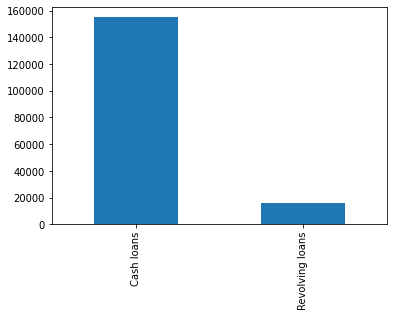

******************** CODE_GENDER ********************



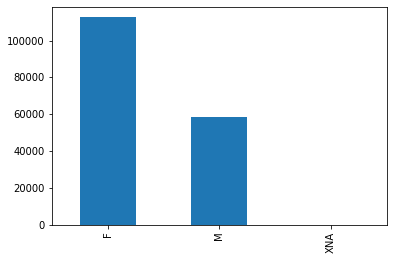

******************** FLAG_OWN_CAR ********************



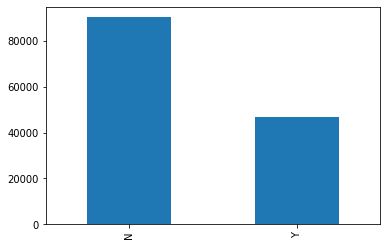

******************** FLAG_OWN_REALTY ********************



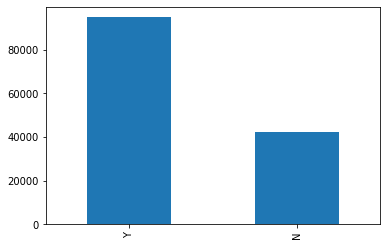

******************** NAME_TYPE_SUITE ********************



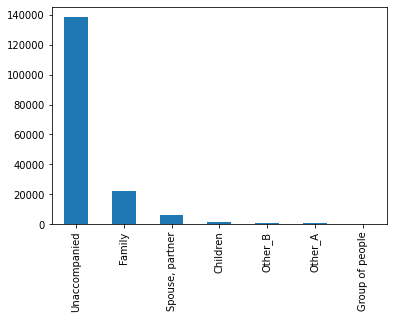

******************** NAME_INCOME_TYPE ********************



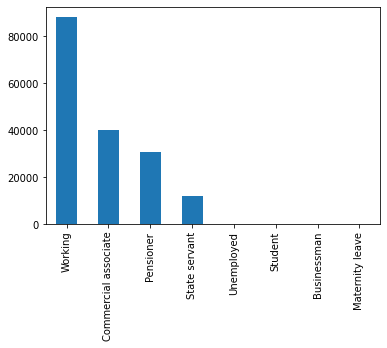

******************** NAME_EDUCATION_TYPE ********************



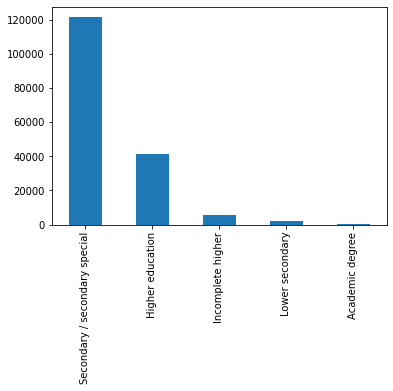

******************** NAME_FAMILY_STATUS ********************



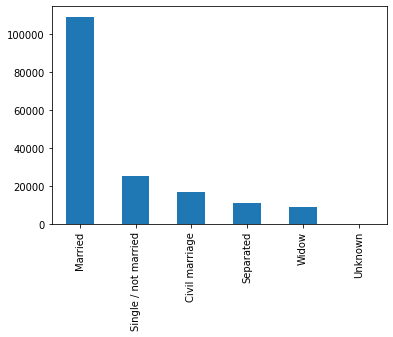

******************** NAME_HOUSING_TYPE ********************



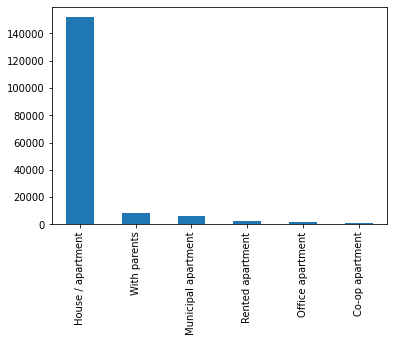

******************** OCCUPATION_TYPE ********************



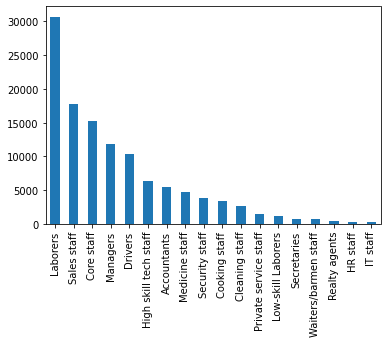

******************** ORGANIZATION_TYPE ********************



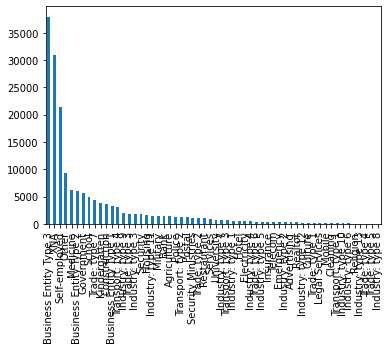

In [49]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [50]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['School' 'XNA' 'Postal' 'Business Entity Type 3' 'Transport: type 4'
 'Trade: type 3' 'Military' 'Self-employed' 'Bank'
 'Business Entity Type 2' 'Kindergarten' 'Trade: type 7' 'Hotel'
 'Services' 'Other' 'Medicine' 'Government' 'Construction' 'Agriculture'
 'University' 'Religion' 'Industry: type 4' 'Advertising' 'Legal Services'
 'Business Entity Type 1' 'Industry: type 9' 'Industry: type 11'
 'Industry: type 3' 'Trade: type 6' 'Industry: type 10' 'Trade: type 1'
 'Housing' 'Industry: type 1' 'Security Ministries' 'Industry: type 12'
 'Security' 'Industry: type 7' 'Transport: type 3' 'Transport: type 2'
 'Police' 'Realtor' 'Restaurant' 'Culture' 'Insurance' 'Emergency'
 'Mobile' 'Electricity' 'Telecom' 'Trade: type 2' 'Industry: type 13'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 5'
 'Industry: type 6' 'Cleaning' 'Trade: type 4' 'Industry: type 8'
 'Trade: type 5'] 


In [51]:
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUS

In [52]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [53]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [54]:
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [55]:
le = LabelEncoder() 
categorical = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,0,0,0,0,6,7,1,1,1,3
1,0,0,0,1,6,3,4,1,1,8
2,0,0,0,1,1,4,4,1,1,3
3,0,0,0,1,0,3,3,5,1,8
4,0,1,0,0,6,1,4,1,5,4


In [56]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (171202, 10)
In test:  (61500, 10)


In [57]:
col_names_cat = categorical.columns

In [58]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [59]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Duplicate Data</h3></center>
</div>

In [60]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 48)
In test:  (0, 47)


# Normalization

In [61]:
x_train = train_new.drop("TARGET", axis = 1)
y = train_new['TARGET']

In [63]:
scaler=MinMaxScaler()
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 
       'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

x_train[col] = pd.DataFrame(scaler.fit_transform(x_train[col]))
test_new[col] = pd.DataFrame(scaler.transform(test_new[col]))

# Modeling with tuned hyperparameters

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
We used Random search for tuning hyperparameters</div>

In [64]:
# Value of hyperparameters for random search

# param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'num_leaves':range(10,100,10),
#              'min_child_samples':range(500,1000,100),
#              'reg_alpha':[0.1,0.01,0.2,0.3],
#              'reg_lambda':[0.1,0.01,0.2,0.3],
#             'n_estimators':range(50,300,50),
#              'max_bin': range(500,1500,100)}

# RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1, class_weight = 'balanced'), 
#              x_train, y, param_lgb)

In [65]:
lgb = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.2, 
                        'num_leaves': 70, 
                        'n_estimators': 250, 
                        'min_child_samples': 800, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

scores = cross_validation(x_train, y, lgb)
print(scores)

Score: 0.742433
None


# Submission

In [66]:
lgb.fit(x_train, y)
y_pred_LGB = lgb.predict(x_train)
y_pred_LGB_test = lgb.predict(test_new)

In [67]:
output = pd.DataFrame({'SK_ID_CURR': test_new.SK_ID_CURR, 
                       'TARGET': lgb.predict_proba(test_new)[:,1]})
output.head()

,SK_ID_CURR,TARGET
0,171202,0.213299
1,171203,0.731108
2,171204,0.615932
3,171205,0.565299
4,171206,0.692801


In [68]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
To be continued... 🚧</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h4 style="padding: 5px 0px; color:#442efb; font-weight: bold; font-family: Cursive">
    Thanks for your attention and for reviewing my notebook.🙌 <br><br>Please write your comments for me.📝</h4></center>
<center><h4 style="padding: 5px 0px; color:#442efb; font-weight: bold; font-family: Cursive">
If you liked my work and found it useful, please upvote. Thank you🙏</h4></center>
</div>

In [69]:
from google.colab import files
files.download('my_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
train1 = train.loc[train['TARGET']==1,:]
train0 = train.loc[train['TARGET']==0,:]

# 電話の変更は490日を区切ると最大のデフォルト率

In [ ]:
train1.loc[train1['DAYS_LAST_PHONE_CHANGE']>-490].count()/train.loc[train['DAYS_LAST_PHONE_CHANGE']>-490].count()


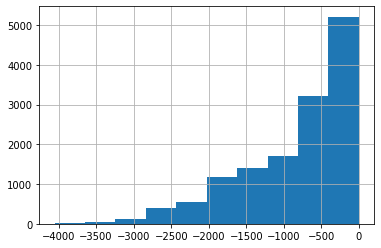

In [153]:
train1['DAYS_LAST_PHONE_CHANGE'].hist()

In [175]:
train1['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

# Cash Loansの方がデフォルト率が高い

In [ ]:
train1.loc[train1['NAME_CONTRACT_TYPE']=='Cash loans'].count()/train.loc[train['NAME_CONTRACT_TYPE']=='Cash loans'].count()

In [ ]:
train1.loc[train1['NAME_CONTRACT_TYPE']== 'Revolving loans'].count()/train.loc[train['NAME_CONTRACT_TYPE']== 'Revolving loans'].count()

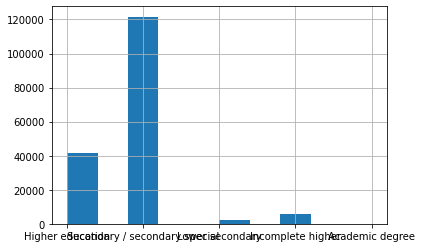

In [180]:
train['NAME_EDUCATION_TYPE'].hist()

In [178]:
train1['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

# 'Academic degree'は0.09％

In [ ]:
train1.loc[train1['NAME_EDUCATION_TYPE']== 'Academic degree'].count()/train.loc[train['NAME_EDUCATION_TYPE']=='Academic degree'].count()


# 'Incomplete higher'は8.72％

In [ ]:
train1.loc[train1['NAME_EDUCATION_TYPE']== 'Incomplete higher'].count()/train.loc[train['NAME_EDUCATION_TYPE']== 'Incomplete higher'].count()


# 'Lower secondary'は11.06％

In [ ]:
train1.loc[train1['NAME_EDUCATION_TYPE']== 'Lower secondary'].count()/train.loc[train['NAME_EDUCATION_TYPE']== 'Lower secondary'].count()

# 'Higher education'は5.37％

In [ ]:
train1.loc[train1['NAME_EDUCATION_TYPE']== 'Higher education'].count()/train.loc[train['NAME_EDUCATION_TYPE']== 'Higher education'].count()

# 'Secondary / secondary special'は8.92％

In [ ]:
train1.loc[train1['NAME_EDUCATION_TYPE']== 'Secondary / secondary special'].count()/train.loc[train['NAME_EDUCATION_TYPE']== 'Secondary / secondary special'].count()

# OWN_CAR　7.3615

In [ ]:
train1.loc[train1['FLAG_OWN_CAR']== 'Y'].count()/train.loc[train['FLAG_OWN_CAR']== 'Y'].count()

# REALTY　　7.9502

In [ ]:
train1.loc[train1['FLAG_OWN_REALTY']== 'Y'].count()/train.loc[train['FLAG_OWN_REALTY']== 'Y'].count()

# 'CNT_CHILDREN'>2 9.85


In [ ]:
train1.loc[train1['CNT_CHILDREN']>2].count()/train.loc[train['CNT_CHILDREN']>2].count()

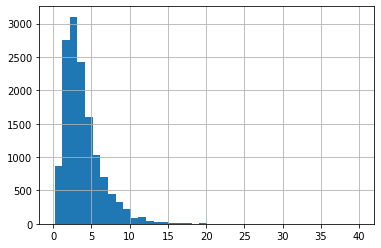

In [194]:
train1['rCreditIncome']=train1['AMT_CREDIT']/train1['AMT_INCOME_TOTAL']
train['rCreditIncome']=train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train1['rCreditIncome'].hist(bins=40)



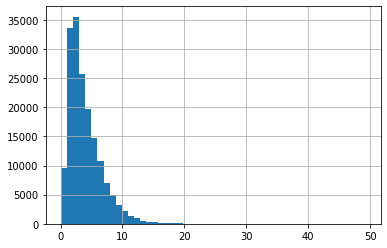

In [195]:
train['rCreditIncome'].hist(bins=50)

# 'AMT_CREDIT'/'AMT_INCOME_TOTAL'>2.1  8.26%

In [ ]:
train1.loc[train1['rCreditIncome']>2.1].count()/train.loc[train['rCreditIncome']>2.1].count()

# 持ち家無く年収の1.5倍の借金は 8.68

In [233]:
train1.loc[(train1['rCreditIncome']>1.5)&(train1['FLAG_OWN_REALTY']=='N')].count()/train.loc[(train['rCreditIncome']>1.5)&(train['FLAG_OWN_REALTY']=='N')].count()


SK_ID_CURR                     0.086779
TARGET                         0.086779
NAME_CONTRACT_TYPE             0.086779
CODE_GENDER                    0.086779
FLAG_OWN_CAR                   0.086779
FLAG_OWN_REALTY                0.086779
CNT_CHILDREN                   0.086779
AMT_INCOME_TOTAL               0.086779
AMT_CREDIT                     0.086779
AMT_ANNUITY                    0.086789
AMT_GOODS_PRICE                0.086794
NAME_TYPE_SUITE                0.087133
NAME_INCOME_TYPE               0.086779
NAME_EDUCATION_TYPE            0.086779
NAME_FAMILY_STATUS             0.086779
NAME_HOUSING_TYPE              0.086779
REGION_POPULATION_RELATIVE     0.086779
DAYS_BIRTH                     0.086779
DAYS_EMPLOYED                  0.086779
DAYS_REGISTRATION              0.086779
DAYS_ID_PUBLISH                0.086779
OWN_CAR_AGE                    0.071954
FLAG_MOBIL                     0.086779
FLAG_EMP_PHONE                 0.086779
FLAG_WORK_PHONE                0.086779


In [174]:
train1.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60